In [1]:
%run 0-Base.ipynb

In [2]:
SOURCE_PATH = f'{DATA_PATH}/5-scaled'

Define a dataset:

In [3]:
from torch.utils.data import Dataset

class EloDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        if self.y is not None:
            return self.X[index], self.y[index]
        else:
            return self.X[index]

Define *train* and *valid* data loaders:

In [4]:
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

X = np.load(f'{SOURCE_PATH}/train/X.npy').astype(np.float32)
y = np.load(f'{SOURCE_PATH}/train/y.npy').astype(np.float32)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=13)

train_dataset = EloDataset(X_train, y_train)
valid_dataset = EloDataset(X_valid, y_valid)

kwargs = dict(shuffle=True)

train_loader = DataLoader(train_dataset, batch_size=2**10, **kwargs)
valid_loader = DataLoader(valid_dataset, batch_size=2**13, **kwargs)

Define a device that will be used for training / evaluation:

In [5]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
from torch import nn

import torch.nn.functional as F

class Regressor(nn.Module):
    def __init__(self):
        super().__init__()

        self.old_transactions_lstm = nn.LSTM(input_size=29,
                                             hidden_size=64,
                                             num_layers=2,
                                             dropout=0.5,
                                             batch_first=True)

        self.new_transactions_lstm = nn.LSTM(input_size=29,
                                             hidden_size=64,
                                             num_layers=2,
                                             dropout=0.5,
                                             batch_first=True)

        self.tail = nn.Sequential(nn.Linear(128, 64),
                                  nn.BatchNorm1d(64),
                                  nn.PReLU(),
                                  nn.Dropout(),
                                  # ---
                                  nn.Linear(64, 32),
                                  nn.BatchNorm1d(32),
                                  nn.PReLU(),
                                  nn.Dropout(),
                                  # ---
                                  nn.Linear(32, 1))

    def forward(self, X):
        out1, _ = self.old_transactions_lstm(X[:,   :-3])
        out2, _ = self.new_transactions_lstm(X[:, -3:  ])

        # get only the last item
        # see many-to-one LSTM arch
        out1 = out1[:, -1]
        out2 = out2[:, -1]

        out = torch.cat((out1, out2), dim=1)
        out = self.tail(out)
        return out

In [7]:
from math import sqrt
from torch import optim
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = Regressor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

# optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-5)
# scheduler = ReduceLROnPlateau(optimizer, verbose=True, factor=0.25, patience=5)

n_epochs = 75
valid_loss_min = np.Inf
writer = SummaryWriter('runs/adam-12')

for epoch in tqdm(range(n_epochs)):
    cum_train_loss = 0.
    cum_valid_loss = 0.

    for X, y in tqdm(train_loader):
        X, y = X.to(device), y.to(device)

        model.train()

        # ZERO PREVIOUS GRADS
        optimizer.zero_grad()

        y_pred = model.forward(X)
        assert y.shape == y_pred.shape
        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()

        cum_train_loss += loss.item()

    model.eval()

    with torch.no_grad():
        for X, y in valid_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model.forward(X)
            assert y.shape == y_pred.shape
            loss = criterion(y_pred, y)

            cum_valid_loss += loss.item()

    train_loss = sqrt(cum_train_loss / X_train.shape[0])
    valid_loss = sqrt(cum_valid_loss / X_valid.shape[0])
    
    writer.add_scalars('loss', dict(train_loss=train_loss, valid_loss=valid_loss), epoch)
    
#     scheduler.step(valid_loss)

    if valid_loss < valid_loss_min:
        print('Validation loss decreased on %02d epoch: %.5f => %.5f | Saving model...' % (epoch + 1, valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


Validation loss decreased on 01 epoch: inf => 3.80896 | Saving model...



Validation loss decreased on 02 epoch: 3.80896 => 3.80661 | Saving model...



Validation loss decreased on 03 epoch: 3.80661 => 3.80540 | Saving model...



Validation loss decreased on 04 epoch: 3.80540 => 3.80398 | Saving model...



Validation loss decreased on 05 epoch: 3.80398 => 3.80283 | Saving model...



Validation loss decreased on 06 epoch: 3.80283 => 3.80190 | Saving model...



Validation loss decreased on 07 epoch: 3.80190 => 3.80089 | Saving model...



Validation loss decreased on 08 epoch: 3.80089 => 3.80001 | Saving model...



Validation loss decreased on 09 epoch: 3.80001 => 3.79939 | Saving model...



Validation loss decreased on 10 epoch: 3.79939 => 3.79860 | Saving model...



Validation loss decreased on 11 epoch: 3.79860 => 3.79771 | Saving model...



Validation loss decreased on 12 epoch: 3.79771 => 3.79730 | Saving model...



Validation loss decreased on 13 epoch: 3.79730 => 3.79640 | Saving model...



Validation loss decreased on 14 epoch: 3.79640 => 3.79624 | Saving model...



Validation loss decreased on 15 epoch: 3.79624 => 3.79540 | Saving model...



Validation loss decreased on 16 epoch: 3.79540 => 3.79474 | Saving model...



Validation loss decreased on 17 epoch: 3.79474 => 3.79419 | Saving model...



Validation loss decreased on 18 epoch: 3.79419 => 3.79360 | Saving model...



Validation loss decreased on 19 epoch: 3.79360 => 3.79307 | Saving model...



Validation loss decreased on 20 epoch: 3.79307 => 3.79234 | Saving model...



Validation loss decreased on 21 epoch: 3.79234 => 3.79200 | Saving model...



Validation loss decreased on 22 epoch: 3.79200 => 3.79131 | Saving model...



Validation loss decreased on 23 epoch: 3.79131 => 3.79108 | Saving model...



Validation loss decreased on 24 epoch: 3.79108 => 3.79063 | Saving model...



Validation loss decreased on 25 epoch: 3.79063 => 3.79004 | Saving model...



Validation loss decreased on 26 epoch: 3.79004 => 3.78948 | Saving model...



Validation loss decreased on 27 epoch: 3.78948 => 3.78909 | Saving model...



Validation loss decreased on 28 epoch: 3.78909 => 3.78839 | Saving model...



Validation loss decreased on 29 epoch: 3.78839 => 3.78792 | Saving model...



Validation loss decreased on 30 epoch: 3.78792 => 3.78731 | Saving model...



Validation loss decreased on 31 epoch: 3.78731 => 3.78696 | Saving model...



Validation loss decreased on 32 epoch: 3.78696 => 3.78631 | Saving model...



Validation loss decreased on 33 epoch: 3.78631 => 3.78574 | Saving model...



Validation loss decreased on 34 epoch: 3.78574 => 3.78516 | Saving model...



Validation loss decreased on 35 epoch: 3.78516 => 3.78489 | Saving model...



Validation loss decreased on 36 epoch: 3.78489 => 3.78400 | Saving model...



Validation loss decreased on 37 epoch: 3.78400 => 3.78368 | Saving model...



Validation loss decreased on 38 epoch: 3.78368 => 3.78294 | Saving model...



Validation loss decreased on 39 epoch: 3.78294 => 3.78218 | Saving model...



Validation loss decreased on 40 epoch: 3.78218 => 3.78159 | Saving model...



Validation loss decreased on 41 epoch: 3.78159 => 3.78102 | Saving model...



Validation loss decreased on 42 epoch: 3.78102 => 3.78052 | Saving model...



Validation loss decreased on 43 epoch: 3.78052 => 3.77952 | Saving model...



Validation loss decreased on 44 epoch: 3.77952 => 3.77933 | Saving model...



Validation loss decreased on 45 epoch: 3.77933 => 3.77888 | Saving model...



Validation loss decreased on 46 epoch: 3.77888 => 3.77833 | Saving model...



Validation loss decreased on 47 epoch: 3.77833 => 3.77757 | Saving model...



Validation loss decreased on 48 epoch: 3.77757 => 3.77669 | Saving model...



Validation loss decreased on 49 epoch: 3.77669 => 3.77591 | Saving model...



Validation loss decreased on 50 epoch: 3.77591 => 3.77517 | Saving model...



Validation loss decreased on 51 epoch: 3.77517 => 3.77461 | Saving model...



Validation loss decreased on 52 epoch: 3.77461 => 3.77387 | Saving model...



Validation loss decreased on 53 epoch: 3.77387 => 3.77309 | Saving model...



Validation loss decreased on 54 epoch: 3.77309 => 3.77193 | Saving model...



Validation loss decreased on 55 epoch: 3.77193 => 3.77128 | Saving model...



Validation loss decreased on 56 epoch: 3.77128 => 3.77002 | Saving model...



Validation loss decreased on 57 epoch: 3.77002 => 3.76904 | Saving model...



Validation loss decreased on 58 epoch: 3.76904 => 3.76781 | Saving model...



Validation loss decreased on 59 epoch: 3.76781 => 3.76735 | Saving model...



Validation loss decreased on 60 epoch: 3.76735 => 3.76615 | Saving model...



Validation loss decreased on 61 epoch: 3.76615 => 3.76545 | Saving model...



Validation loss decreased on 62 epoch: 3.76545 => 3.76502 | Saving model...



Validation loss decreased on 63 epoch: 3.76502 => 3.76425 | Saving model...



Validation loss decreased on 64 epoch: 3.76425 => 3.76315 | Saving model...



Validation loss decreased on 65 epoch: 3.76315 => 3.76222 | Saving model...



Validation loss decreased on 66 epoch: 3.76222 => 3.76146 | Saving model...



Validation loss decreased on 67 epoch: 3.76146 => 3.76103 | Saving model...



Validation loss decreased on 68 epoch: 3.76103 => 3.75962 | Saving model...



Validation loss decreased on 69 epoch: 3.75962 => 3.75837 | Saving model...



Validation loss decreased on 70 epoch: 3.75837 => 3.75711 | Saving model...



Validation loss decreased on 71 epoch: 3.75711 => 3.75693 | Saving model...



Validation loss decreased on 72 epoch: 3.75693 => 3.75578 | Saving model...



Validation loss decreased on 73 epoch: 3.75578 => 3.75409 | Saving model...



Validation loss decreased on 74 epoch: 3.75409 => 3.75308 | Saving model...


Validation loss: 3.75308


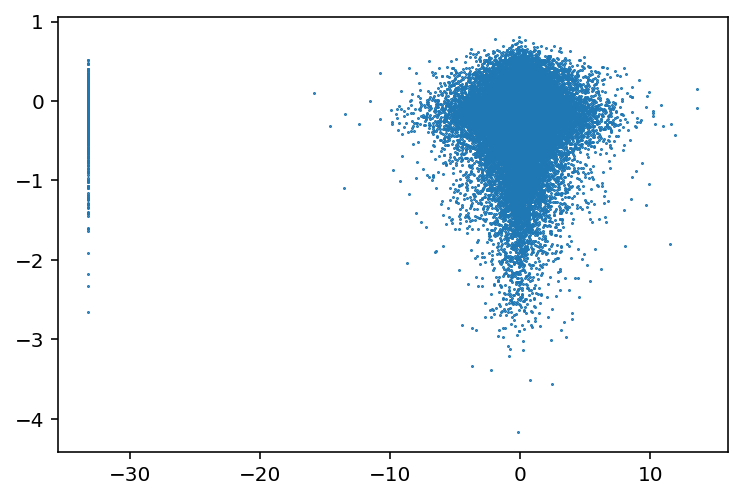

In [8]:
criterion = nn.MSELoss(reduction='sum')

model = Regressor().to(device).eval()
model_state_dict = torch.load('model.pt')
model.load_state_dict(model_state_dict)

y_valid_pred = []
cum_valid_loss = 0.

with torch.no_grad():
    for X, y in valid_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model.forward(X)
        y_valid_pred.append(y_pred.cpu().numpy())

        assert y.shape == y_pred.shape
        loss = criterion(y_pred, y)

        cum_valid_loss += loss.item()

y_valid_pred = np.concatenate(y_valid_pred)
assert y_valid.shape == y_valid_pred.shape

valid_loss = (cum_valid_loss / X_valid.shape[0]) ** 0.5
print('Validation loss: %.5f' % valid_loss)

plt.scatter(y_valid, y_valid_pred, s=0.25);

In [9]:
X_test, y_test = np.load(f'{SOURCE_PATH}/test/X.npy').astype(np.float32), []

test_dataset = EloDataset(X_test)

test_loader = DataLoader(test_dataset, batch_size=2**13)

with torch.no_grad():
    for X in test_loader:
        X = X.to(device)
        y_pred = model.forward(X)
        y_test.append(y_pred.cpu().numpy())

y_test = np.concatenate(y_test)
display(y_test)

array([[-0.3196453 ],
       [-0.35287833],
       [ 0.15942076],
       ...,
       [-1.1818323 ],
       [-0.58163846],
       [ 0.25888705]], dtype=float32)

In [10]:
submission_df = pd.read_csv(f'{DATA_PATH}/raw/sample_submission.csv').sort_values('card_id')
submission_df.target = y_test
display(submission_df)

submission_df.to_csv('submission.csv', index=False)

,card_id,target
9030,C_ID_0001238066,-0.319645
48429,C_ID_0001793786,-0.352878
59611,C_ID_00024e244b,0.159421
22596,C_ID_0002709b5a,-0.359864
65546,C_ID_000298032a,-0.048846
...,...,...
57732,C_ID_fffd337484,-1.095349
19017,C_ID_fffd345048,-0.264100
39078,C_ID_fffd943b91,-1.181832
49255,C_ID_ffff1d9928,-0.581638
